## <font color=red> Temporary header </font>

In [1]:
%load_ext autoreload
%autoreload 2

# Short Text Clustering

The following work is mainly inspired by:
- 2014 - Convolutional Neural Networks for Sentence Classification
- 2014 - A Convolutional Neural Network for Modelling Sentences
- 2017 - Self-Taught Convolutional Neural Networks for Short Text Clustering

Word embedding from fasttext are distributed under the license:
- Creative Commons Attribution-Share-Alike License 3.0 (free commercial use)

# Import

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

src_emb = "./embeddings/"
src_stc = "./data/short_texts/"

In [3]:
# Dataset for short text clustering
os.listdir(src_stc)

['Biomedical.txt',
 'Biomedical_gnd.txt',
 'SearchSnippets.txt',
 'SearchSnippets_gnd.txt',
 'StackOverflow.txt',
 'StackOverflow_gnd.txt']

In [4]:
# Word embedding 
os.listdir(src_emb)

['fasttext.wiki.en.vec', 'glove100K.100d.vec']

# Fetching the data

#### Loading pre-trained Glove word embedding

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

In [5]:
"""
%%time

glove_embeddings_index = {}
glove_embeddings_vectors = []

with open(src_emb + 'glove100K.100d.vec', 'rb') as f:
    word_idx = 0
    for line in tqdm_notebook(f, total=100000):
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = word_idx
        glove_embeddings_vectors.append(vector)
        word_idx = word_idx + 1

glove_inv_index = {v: k for k, v in glove_embeddings_index.items()}
print("found %d different words in the file" % word_idx) # Fetching word embedding from the web
"""
print("Glove desactivated")

Glove desactivated


#### Loading pre-trained Fasttext word embedding

Pre-trained word vectors for french languages, trained on Wikipedia using fastText. These vectors in dimension `300` were obtained using the skip-gram model described in `Bojanowski et al.(2016)` with default parameters.

We extracted the `100 000` most frequent words. They have a dimension of `300`

In [6]:
%%time

fast_embeddings_index = dict()
fast_embeddings_vectors = list()
total = 1 * int(1e5)

tmp_emb = list()

with open(src_emb + 'fasttext.wiki.en.vec', 'rb') as f:
    head = f.readline().decode('utf-8')
    for word_idx in tqdm_notebook(range(total), total=total):
        raw = f.readline().decode('utf-8').rstrip(' \n')
        tmp_emb.append(raw + ' \n')
        line = raw.split(' ')
        word = line[0]
        vector = np.asarray(line[1:], dtype='float32')
        fast_embeddings_index[word] = word_idx
        fast_embeddings_vectors.append(vector)
        
fast_inv_index = {v: k for k, v in fast_embeddings_index.items()}
print("found %d different words in the file" % total)


found 100000 different words in the file
Wall time: 13 s


In [7]:
# Storing each embedding model
embedding_model = {}
embedding_model['fasttext'] = [fast_embeddings_index, fast_embeddings_vectors, fast_inv_index]
#embedding_model['glove'] = [glove_embeddings_index, glove_embeddings_vectors, glove_inv_index]

# Word embedding

In [8]:
#embedding_name = 'glove'
embedding_name = 'fasttext'
embeddings_index, embeddings_vectors, inv_index = embedding_model[embedding_name]

In [9]:
# Stack all embeddings in a large numpy array
embeddings = np.vstack(embeddings_vectors)
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
embeddings_normed = embeddings / norms
print(embeddings.shape)

(100000, 300)


In [10]:
emb_shape = np.shape(embeddings[0])

def zeros_init():
    return np.zeros(shape=emb_shape)

def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return zeros_init()
    else:
        return embeddings[idx]

def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return zeros_init()
    else:
        return embeddings_normed[idx]

In [11]:
epsilon = 1e-5

def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)       
    else:
        query_emb = get_emb(words)
        
    query_emb = query_emb / (np.linalg.norm(query_emb) + epsilon)
    
    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(embeddings_normed, query_emb)
    
    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1][:topn]
    
    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [12]:
most_similar('maths')

[('maths', 0.99999785),
 ('mathematics', 0.7072618),
 ('math', 0.70355952),
 ('gcse', 0.66205692),
 ('gcses', 0.60882735),
 ('igcse', 0.57441127),
 ('homework', 0.56958681),
 ('numeracy', 0.56879795),
 ('arithmetic', 0.54979849),
 ('physics', 0.54030263)]

In [13]:
most_similar('napoleon')

[('napoleon', 0.99999762),
 ('bonaparte', 0.77908337),
 ('napoléon', 0.71624577),
 ('napoleonic', 0.69677263),
 ('davout', 0.66151655),
 ('austerlitz', 0.6409688),
 ('masséna', 0.63768828),
 ('beauharnais', 0.63125008),
 ('soult', 0.62394285),
 ('talleyrand', 0.61470497)]

# Data exploration

#### Loading data

In [14]:
#data_name = "Biomedical"
data_name = "StackOverflow"

with open(src_stc + '%s.txt' % data_name, encoding="utf-8") as f:
    data = f.readlines()
data = [text.rstrip('\n') for text in data]

with open(src_stc + '%s_gnd.txt' % data_name, encoding="utf-8") as f:
    target = f.readlines()
target = [int(label.rstrip('\n')) for label in target]
    
print("short texts")
n_max = 10
__ = [print("%d --" %label, txt) for txt, label in zip(data[:n_max], target[:n_max])]
print("\n Total: %s texts" % format(len(data), ","))

short texts
18 -- How do I fill a DataSet or a DataTable from a LINQ query resultset ?
18 -- How do you page a collection with LINQ?
3 -- Best Subversion clients for Windows Vista (64bit)
3 -- Best Practice: Collaborative Environment, Bin Directory, SVN
7 -- Visual Studio Setup Project - Per User Registry Settings
18 -- How do I most elegantly express left join with aggregate SQL as LINQ query
7 -- .Net XML comment into API Documentation
15 -- Modify Address Bar URL in AJAX App to Match Current State
7 -- Integrating Visual Studio Test Project with Cruise Control
10 -- What should a longtime Windows user know when starting to use Linux?

 Total: 20,000 texts


In [15]:
# Random sample 

n = len(data)
sample = 2000
print("Loading %s samples" % format(sample, ","))
index_sample = np.random.randint(0, n, sample)

data = [data[idx] for idx in index_sample]
target = [target[idx] for idx in index_sample]

Loading 2,000 samples


In [16]:
most_similar('stackoverflow')

[('hemophilia', 0.0),
 ('penney', 0.0),
 ('leconte', 0.0),
 ('remodelled', 0.0),
 ('bdsm', 0.0),
 ('cité', 0.0),
 ('newry', 0.0),
 ('camberwell', 0.0),
 ('lightfoot', 0.0),
 ('outburst', 0.0)]

#### Splitting dataset into train-test

In [17]:
from sklearn.model_selection import train_test_split

# train test split of dataset
train, test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)
print("train size: %d" % len(train))
print("test size: %d" % len(test))

train size: 1800
test size: 200


In [18]:
from keras.preprocessing.text import Tokenizer

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(train)
sequences_train = tokenizer.texts_to_sequences(train)
sequences_test = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_NB_WORDS = len(word_index)

Using TensorFlow backend.


Found 3107 unique tokens.


#### Let's look at the length of the data

average length: 8.6
max length: 33


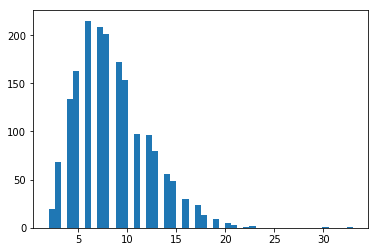

In [19]:
seq_lens = [len(s) for s in sequences_train]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
plt.hist(seq_lens, bins=50);

In [20]:
from keras.preprocessing.sequence import pad_sequences

# according to previous cell
MAX_SEQUENCE_LENGTH = max(seq_lens)

# pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', np.shape(X_train))
print('Shape of data test tensor:', np.shape(X_test))

Shape of data tensor: (1800, 33)
Shape of data test tensor: (200, 33)


In [21]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(np.asarray(y_train))
Y_test = to_categorical(np.asarray(y_test))
print('Shape of label tensor:', Y_train.shape)
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (1800, 21)
Shape of label tensor: (200, 21)


In [22]:
# creating embedding matrix

EMBEDDING_DIM = emb_shape[0]
N_CLASSES = 21

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = get_emb(word)
    embedding_matrix[i] = embedding_vector
    nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 3107 words in the embedding matrix


# CNN

In [23]:
from keras.layers import Input, Embedding, Flatten, Reshape
from keras.layers import Dense, Conv1D, Dropout, merge
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, ZeroPadding1D
from keras.models import Model

# Note, on this type of task, this technique will 
# degrade results as we train much less parameters
# and we average a large number pre-trained embeddings.
# You will notice much less overfitting then!
# Using convolutions / LSTM will help
# It is also advisable to treat seperately pre-trained
# embeddings and words out of vocabulary.

In [24]:
embedding_matrix_copy = embedding_matrix.copy()
trainable_layer = True

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# Layer
x = Conv1D(100, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)

# Output
predictions = Dense(N_CLASSES, activation='softmax')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_layer

# Model hyper-parameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#model.summary()

In [25]:
%%time
model.fit(X_train, Y_train, validation_split=0.1,
          nb_epoch=3, batch_size=128, verbose=2)

C:\PYTHON_PYCHARM\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 1620 samples, validate on 180 samples
Epoch 1/3
2s - loss: 2.8357 - acc: 0.2191 - val_loss: 2.5758 - val_acc: 0.4389
Epoch 2/3
2s - loss: 2.2283 - acc: 0.5278 - val_loss: 2.0283 - val_acc: 0.6333
Epoch 3/3
2s - loss: 1.6941 - acc: 0.6852 - val_loss: 1.5816 - val_acc: 0.7056
Wall time: 7.94 s


In [26]:
from sklearn.metrics import accuracy_score
proba = model.predict(X_test)
pred = np.argmax(proba, axis=1)
acc = accuracy_score(y_test, pred)*100
print("Accuracy: %0.02f pct" % acc)

Accuracy: 72.00 pct


# Deep feature representations learning

In [27]:
""" Be careful, dataset was shuffled during train-test split. """
# sequences
n_train = len(sequences_train)
n_test = len(sequences_test)
sequences = sequences_train + sequences_test
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
Y = dict()

# tf-idf
tfidf = tokenizer.sequences_to_matrix(sequences, mode='tfidf')

# label
y = y_train + y_test

# dictionary of reduction methods' name
reduction_methods = {"le": "laplacian eigenvalues",
                     "ae": "average embeddings",
                     "lsa": "latent semantic analysis"}

#### Average embeddings (AE)

``
%%time
denom = 1 + np.sum(tfidf, axis=1)[:, None]
normed_tfidf = tfidf/denom
average_embeddings = np.dot(normed_tfidf, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)
``

#### Latent Semantic Analysis (LSA)

In [28]:
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# self coded package
from utils.target import laplacian_eigenmaps, binarize

In [29]:
%%time
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
L = lsa.fit_transform(tfidf)
Y["lsa"] = L
print("Shape of latent semantic vectors: ", Y['lsa'].shape)

Shape of latent semantic vectors:  (2000, 100)
Wall time: 1.07 s


#### Laplacian Eigenmaps (LE) [memory intensive]

In [30]:
%%time

# eigen vectors from graph of text similarity
E = laplacian_eigenmaps(L, n_neighbors=15, subdim=15, n_jobs=-1)
Y["le"] = E

Fitting nearest neighbors...
Creation of affinity matrix...
Creation of heat kernel affinity matrix...
spectral embedding
Wall time: 1.79 s


In [31]:
print(E.shape)
print()
print(E[0])

(2000, 15)

[-0.01114988 -0.01451746 -0.0354862   0.02196536  0.017482    0.00608473
  0.02578526  0.00057846 -0.00231558  0.01104013  0.00559103  0.0033658
  0.00056908  0.01187031  0.01614356]


#### Binary feature

In [32]:
reduction_name = "le"
B = binarize(Y[reduction_name])

# Last dimension in the CNN
LAST_DIMENSION = B.shape[1]

In [33]:
print(B.shape)
print()
print(B[0])

(2000, 15)

[ 0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.]


In [34]:
B_train = B[:n_train]
B_test = B[n_train:]

#### CNN for deep feature representation learning 

Remarks:
- Two layers is better
- Activation tanh slightly better than relu
- Setting trainable layer to "True", we achieved in 10 epochs with batch=50 a very good performance (0.32 with current architecture)

To try:
- Use multiple layers

In [35]:
embedding_matrix_copy = embedding_matrix.copy()
trainable_embedding = False

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# 1st Layer
x = Conv1D(100, 5, activation='tanh', border_mode='same')(embedded_sequences)
# x = AveragePooling1D(pool_length=2, stride=2, border_mode='same')(x)
# x = MaxPooling1D(pool_length=2, border_mode='same')(x)

# 2nd Layer
# x = Conv1D(200, 5, activation='tanh', border_mode='same')(x)
x = AveragePooling1D(pool_length=2, stride=2, border_mode='same')(x)
x = GlobalMaxPooling1D()(x)

# Output
x = Dropout(0.5)(x)
predictions = Dense(LAST_DIMENSION, activation='sigmoid')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_embedding

# Model hyper-parameters
losses = {'bc': 'binary_crossentropy',
          'cc': 'categorical_crossentropy',
          'mse': 'mse',
          'mae': 'mae',
         }

# Loss and Optimizer
loss_name = 'bc'
model.compile(loss=losses[loss_name],
              optimizer='adam',
              metrics=['mae'])

model.summary()

C:\PYTHON_PYCHARM\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(100, 5, activation="tanh", padding="same")`
C:\PYTHON_PYCHARM\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(pool_size=2, strides=2, padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 33)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 33, 300)           932400    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 100)           150100    
_________________________________________________________________
average_pooling1d_1 (Average (None, 17, 100)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1515      
Total para

In [36]:
%%time
nb_epoch = 3
model.fit(X, B, validation_split=0.2,
          epochs=nb_epoch, batch_size=100, verbose=2)

Train on 1600 samples, validate on 400 samples
Epoch 1/3
2s - loss: 0.6732 - mean_absolute_error: 0.4836 - val_loss: 0.6518 - val_mean_absolute_error: 0.4737
Epoch 2/3
2s - loss: 0.6313 - mean_absolute_error: 0.4598 - val_loss: 0.6181 - val_mean_absolute_error: 0.4543
Epoch 3/3
2s - loss: 0.5960 - mean_absolute_error: 0.4364 - val_loss: 0.5893 - val_mean_absolute_error: 0.4340
Wall time: 6.75 s


#### Deep feature representations h

In [37]:
from keras.models import Model

# take the penultimate layer
input = model.layers[0].input
output = model.layers[-2].output

# Take the output of the layer just before the AveragePooling2D
model_h = Model(input, output)

In [38]:
%%time
H = model_h.predict(X)

Wall time: 804 ms


In [39]:
print("Sample shape: {}".format(H.shape))

Sample shape: (2000, 100)


# Tools for evaluating cluster quality

In [40]:
from sklearn.preprocessing import normalize
from collections import Counter
from operator import itemgetter

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())
    mapping = dict()
    n_label = len(np.unique(true_labels))
    
    # Get most likely mapping based on counts
    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0]
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

def cluster_quality(true_labels, pred_labels):    
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    print("Homogeneity: %0.3f" % h)
    print("Completeness: %0.3f" % c)
    print("V-measure: %0.3f" % v)
    print("NMI: %0.3f" % nmi)
    print("Rand: %0.3f" % rand)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = accuracy_score(true_labels, pred_labels_mapped)
    print("Acc: %0.3f" % acc)

# K-means on deep feature representations

In [41]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA

# normalize deep feature representation
V = normalize(H, norm='l2')

In [42]:
%%time
#km = MiniBatchKMeans(n_clusters=20, init_size=1000, batch_size=1000, n_init=1)
km = KMeans(n_clusters=20, n_init=1)
km.fit(V)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.572
Completeness: 0.581
V-measure: 0.577
NMI: 0.577
Rand: 0.437
Acc: 0.607
Wall time: 111 ms


In [43]:
# parameters of deep feature representation learning
print("Deep feature learning parameters \n")

print("Number of epochs: %s" % nb_epoch)
print("Reduction name: %s" % reduction_methods[reduction_name])
print("Trainable word embedding layer: %s" % str(trainable_embedding))

Deep feature learning parameters 

Number of epochs: 3
Reduction name: laplacian eigenvalues
Trainable word embedding layer: False


# K-means on tfidf

In [44]:
from sklearn.decomposition import TruncatedSVD

In [45]:
%%time
svd = TruncatedSVD(n_components=100)
LSA = svd.fit_transform(tfidf)
LSA = normalize(LSA)
print(LSA.shape)

(2000, 100)
Wall time: 1.42 s


In [46]:
%%time

km = KMeans(n_clusters=20, n_init=1)
km.fit(LSA)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.568
Completeness: 0.598
V-measure: 0.583
NMI: 0.583
Rand: 0.340
Acc: 0.609
Wall time: 119 ms


# Cluster visualization

In [47]:
%matplotlib inline
from matplotlib import pyplot as plt
from webcolors import name_to_rgb
from sklearn.manifold import TSNE

color_names = ['SeaGreen', 'Sienna', 'Silver', 'Navy', 'Purple', 'SlateGrey', 'Orange',
               'SpringGreen', 'SteelBlue', 'Lime', 'Teal', 'Thistle', 'Tomato', 'Turquoise',
               'Violet', 'OrangeRed', 'Black', 'Red', 'Yellow', 'YellowGreen']

# number of samples to visualize because tsne is slow
n_sample = 2000
index_sample = np.random.randint(low=0, high=sample, size=(n_sample,))

# mapping color to sample
true_labels = y
labels = np.unique(true_labels)
colormap = {label: color for label, color in zip(labels, color_names)}
colors = [colormap[x] for x in true_labels[:n_sample]]

# plot function
def plot_tsne(T):
    color_rgb = [name_to_rgb(name) for name in colors]
    color_rgb_norm = [(x/255., y/255., z/255.) for x, y, z in color_rgb]
    plt.figure(figsize=(10, 10))
    plt.scatter(T[:, 0], T[:, 1], c=color_rgb_norm, s=60)

#### T-SNE embedding on deep feature representations

Remarks:
- Using Laplacian Eigenvalues, we obtain very dense clusters
- Using LSA as target, results are also quite good
- LSA is very competitive for accuracy

In [48]:
# T-SNE model
tsne = TSNE(n_components=2, 
            perplexity=30, early_exaggeration=4.,
            init="pca", metric="euclidean")

In [49]:
%%time
W = V[:n_sample]
T = tsne.fit_transform(W)

Wall time: 15.3 s


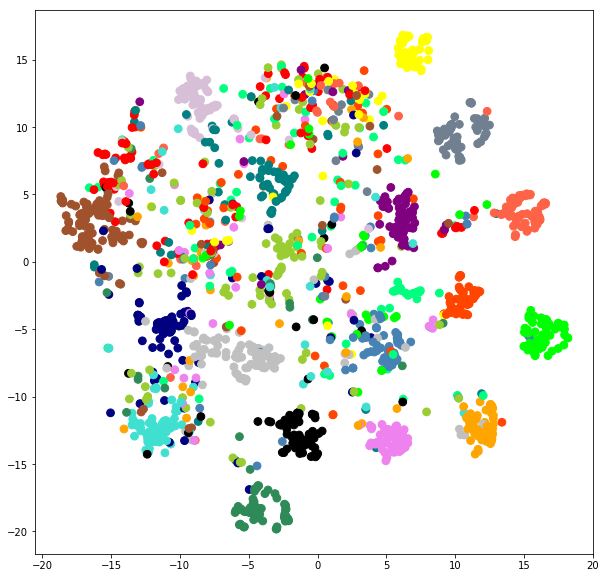

In [50]:
plot_tsne(T)

#### T-SNE embedding on LSA

In [51]:
%%time
L = tsne.fit_transform(LSA[:n_sample])

Wall time: 22 s


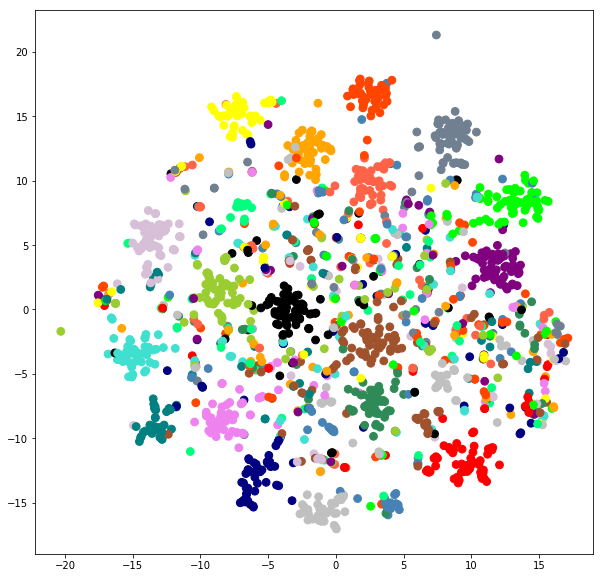

In [52]:
# matplotlib visualization
plot_tsne(L)

# Testing K-means on laplacian eigenvalues

In [53]:
%%time
NB = normalize(Y["le"])
km = KMeans(n_clusters=20, n_init=1)
km.fit(NB)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.518
Completeness: 0.532
V-measure: 0.525
NMI: 0.525
Rand: 0.425
Acc: 0.617
Wall time: 62.4 ms


In [54]:
%%time
LE = Y["le"]
TLE = tsne.fit_transform(LE[:n_sample])

Wall time: 18.7 s


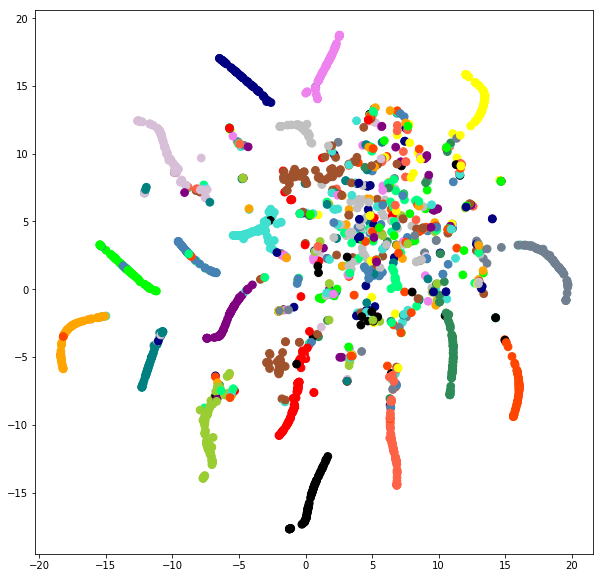

In [55]:
plot_tsne(TLE)